# We're going to try fitting a full asymptotic relation to some simulated data

We'll do Gaussian noise cos it makes my life easier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

from utils import *

import pymc3 as pm
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [19]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, l, m):
    #We use the prescriptions from Gizon & Solanki 2003 and Handberg & Campante 2012
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4
        if l == 3:
            if m == 0:
                return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
            if np.abs(m) == 1:
                return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
            if np.abs(m) == 2:
                return (15/8) * np.cos(i)**2 * np.sin(i)**4
            if np.abs(m) == 3:
                return (5/16)*np.sin(i)**6

    def epsilon(self, i, mm=tt):
       
        eps = np.zeros([3,3])
        
        eps[0,0] = 1.
        eps[1,0] = mm.cos(i)**2
        eps[1,1] = 0.5 * mm.sin(i)**2
        eps[2,0] = 0.25 * (3. * mm.cos(i)**2 - 1.)**2
        eps[2,1] = (3./8.)*mm.sin(2*i)**2
        eps[2,2] = (3./8.) * mm.sin(i)**4
    
        return eps


    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0, mm=tt):
        eps = self.epsilon(i, mm)
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, mm=tt):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i, mm=mm)
        self.mode(1, f1, h1, g1, i, split, mm=mm)
        self.mode(2, f2, h2, g2, i, split, mm=mm)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    def asymptotic(self, n, numax, deltanu, alpha, epsilon):       
        nmax = (numax / deltanu) - epsilon
        over = (n + epsilon + ((alpha/2)*(nmax - n)**2))
        return over * deltanu
    
    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n1, numax, deltanu, alpha, epsilon)
        return f0 + d01
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon)
        return f0 - d02

In [20]:
nmodes = 1
nbase = 13
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .1
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

In [21]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.
epsilon_ = 1.
d01_ = deltanu_/2.
d02_ = 6.

In [22]:
mod = model(ff, n0_, n1_, n2_)

In [23]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]
f0_ = mod.f0(init_f)
f1_ = mod.f1(init_f)
f2_ = mod.f2(init_f)

In [24]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [25]:
mod = model(f, n0_, n1_, n2_)

In [26]:
init_m =[f0_,                         # l0 modes
           f1_,                         # l1 modes
           f2_,                         # l2 modes
           np.ones(len(f0_)) * 2.0,     # l0 widths
           np.ones(len(f1_)) * 2.0,     # l1 widths
           np.ones(len(f2_)) * 2.0,     # l2 widths
           np.sqrt(gaussian(f0_, 0, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l0 heights
           np.sqrt(gaussian(f1_, 1, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l1 heights
           np.sqrt(gaussian(f2_, 2, numax_, 15.) * 2.0 * np.pi / 2.0) ,# l2 heights
           1,       # splitting
           np.pi/2.,                    # inclination angle
           1.                           # background parameters
        ]
p = mod.model(init_m, mm=np, nump=True)#+np.random.normal(0., 0.1, size=len(f))

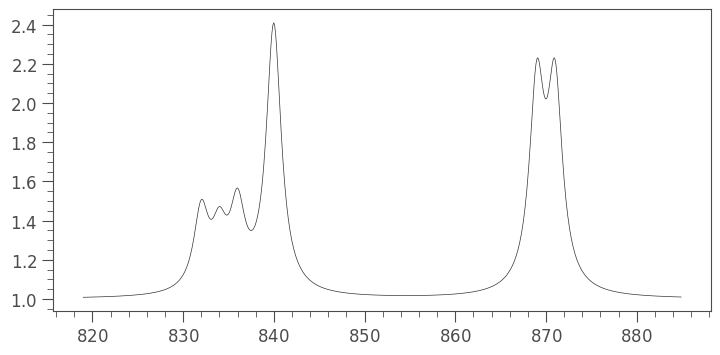

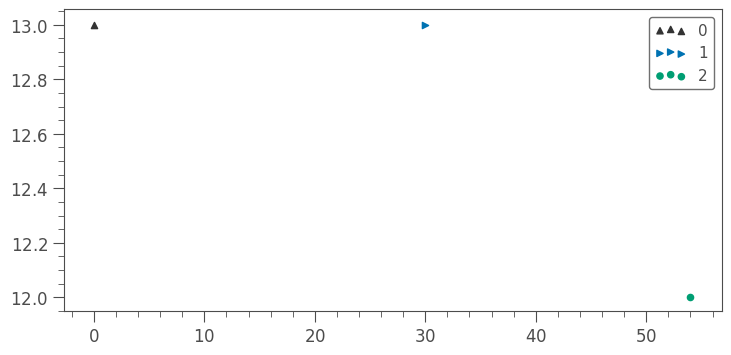

In [27]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(f0_%deltanu_, n0_, marker='^',label='0', s=20)
    ax.scatter(f1_%deltanu_, n1_, marker='>',label='1', s=20)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='2', s=20)

    ax.legend()
    plt.show()    

# Now lets try and fit this

In [28]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax = BNormal('numax', mu=numax_, sd=100., testval=numax_)
    deltanu = BNormal('deltanu', mu=deltanu_, sd=1., testval=deltanu_)
    epsilon = BNormal('epsilon', mu=epsilon_, sd=1., testval=epsilon_)
    d01 = BNormal('d01', mu=d01_, sd=10., testval=d01_)
    d02 = BNormal('d02', mu=d02_, sd=2., testval=d02_)
    
    f0 = pm.Deterministic('f0', mod.f0([numax, deltanu, 0., epsilon, d01, d02]))
    f1 = pm.Deterministic('f1', mod.f1([numax, deltanu, 0., epsilon, d01, d02]))
    f2 = pm.Deterministic('f2', mod.f2([numax, deltanu, 0., epsilon, d01, d02]))

#     f0 = pm.Normal('f0', mu=f0_, sigma=1., testval=f0_, shape=(len(f0_)))
#     f1 = pm.Normal('f1', mu=f1_, sigma=1., testval=f1_, shape=(len(f1_)))
#     f2 = pm.Normal('f2', mu=f2_, sigma=1., testval=f2_, shape=(len(f2_)))

    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))

    a0 = pm.HalfNormal('a0', sigma=20., testval=init_m[6], shape=len(init_m[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init_m[7], shape=len(init_m[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init_m[8], shape=len(init_m[8]))
    
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Normal('like', mu=fit, sd=.1, observed=p)

TypeError: 'TensorConstant' object does not support item assignment

In [ ]:
with pm_model:
    trace = pm.sample(chains=4, tune=100, draws=200)

In [ ]:
pm.traceplot(trace)
plt.show()

In [ ]:
pm.summary(trace)

# Now lets plot some diagnostics...

In [ ]:
labels=['xsplit','cosi','split','i','b',
        'numax','deltanu','epsilon','d01','d02']
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$\delta\nu_{\rm s}$', r'$i$','b',
           r'$\nu_{\rm max}$',r'$\Delta\nu$',r'$\epsilon$',r'$\delta\nu_{01}$',r'$\delta\nu_{02}$']

In [ ]:
truths = [init_m[9] * np.sin(init_m[10]), np.cos(init_m[10]), init_m[9], init_m[10], 1.,
          numax_, deltanu_, epsilon_, d01_, d02_]
chain = np.array([trace[label] for label in labels])

corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,truths=truths, show_titles=True)
plt.show()